In [1]:
from tensorflow.keras.models import load_model

model = load_model('content/resnet50.hdf5')

In [182]:
from tensorflow.keras.models import Model
model= Model(inputs=model.input, outputs=model.layers[-2].output)
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
_______________________________________________________________________________________

In [183]:
import os
path_to_fonts = 'font'
filelist = []
for root, dirs, files in os.walk(path_to_fonts): 
    for file in files: 
        filelist.append(file)

In [184]:
filelist = filelist[:1]

In [185]:
import numpy as np
from PIL import Image
path_to_fonts = 'img'
X_data = []
Y_data=[]
for root, dirs, files in os.walk(path_to_fonts): 
    for file in files: 
        for font in filelist:
            if(font in file and '30' in file):
                X_data.append(np.asarray(Image.open(os.path.join(root,file))).astype('int8'))
                Y_data.append(os.path.join(root,file)[4:5])

In [186]:
X_data = np.array(X_data)

In [187]:
result_vector_embedding = model(X_data)

print(np.shape(result_vector_embedding))

(8184, 2048)


In [164]:
result_vector_embedding[1]

<tf.Tensor: shape=(2048,), dtype=float32, numpy=
array([1.1366959 , 0.        , 0.80334556, ..., 0.40624148, 0.03451697,
       0.65488684], dtype=float32)>

In [188]:
import numpy as np
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Lambda, BatchNormalization, Dropout

In [189]:
hidden_dim = 1500
batch_size = 44 
 
def dropout_and_batch(x):
  return Dropout(0.4)(BatchNormalization()(x))

In [190]:
#энкодер
input_img = Input((2048))
x = Dense(256, activation='relu')(input_img)
x = dropout_and_batch(x)
x = Dense(128, activation='relu')(x)
x = dropout_and_batch(x)
#Вектор z_mean – это МО, а вектор z_log_var – логарифм дисперсий  
z_mean = Dense(hidden_dim)(x)
z_log_var = Dense(hidden_dim)(x)

In [191]:
def noiser(args):
  global z_mean, z_log_var
  z_mean, z_log_var = args
  N = K.random_normal(shape=(batch_size, hidden_dim), mean=0., stddev=1.0)
  return K.exp(z_log_var / 2) * N + z_mean

In [192]:
h = Lambda(noiser, output_shape=(hidden_dim,))([z_mean, z_log_var])

In [193]:
input_dec = Input(shape=(hidden_dim,))
d = Dense(128, activation='relu')(input_dec)
d = dropout_and_batch(d)
d = Dense(256, activation='relu')(input_dec)
d = dropout_and_batch(d)
decoded = Dense(2048, activation='sigmoid')(d)

In [194]:
encoder = Model(input_img, h, name='encoder')
decoder = Model(input_dec, decoded, name='decoder')
vae = Model(input_img, decoder(encoder(input_img)), name="vae")
z_meaner = Model(input_img, z_mean, name='Enc_z_mean')
z_lvarer = Model(input_img, z_log_var, name='Enc_z_log_var')

In [195]:
def vae_loss(x, y):
  x = K.reshape(x, shape=(batch_size, 2048))
  y = K.reshape(y, shape=(batch_size, 2048))
  # первый критерий – разница между входным и выходным сигналами
  loss = 2048*binary_crossentropy(x, y)
  #вычисление второго критерия – расстояния Кульбака-Лейблера по тензорам z_mean и z_log_var.  
  kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
  return (loss + kl_loss)/2/2048

In [196]:
from sklearn import preprocessing
normalized_arr = preprocessing.normalize(result_vector_embedding)

In [197]:
vae.compile(optimizer=Adam(lr=0.0001), loss=vae_loss)

In [198]:
vae.fit(normalized_arr, normalized_arr, batch_size=batch_size, epochs=500)

Epoch 1/500
186/186 [==============================] - 2s 12ms/step - loss: 0.4179
Epoch 2/500
186/186 [==============================] - 2s 12ms/step - loss: 0.3782
Epoch 3/500
186/186 [==============================] - 2s 12ms/step - loss: 0.3361
Epoch 4/500
186/186 [==============================] - 2s 12ms/step - loss: 0.2728
Epoch 5/500
186/186 [==============================] - 2s 12ms/step - loss: 0.2001
Epoch 6/500
186/186 [==============================] - 2s 12ms/step - loss: 0.1437
Epoch 7/500
186/186 [==============================] - 2s 12ms/step - loss: 0.1054
Epoch 8/500
186/186 [==============================] - 2s 12ms/step - loss: 0.0828
Epoch 9/500
186/186 [==============================] - 2s 12ms/step - loss: 0.0705
Epoch 10/500
186/186 [==============================] - 2s 12ms/step - loss: 0.0621
Epoch 11/500
186/186 [==============================] - 2s 12ms/step - loss: 0.0565
Epoch 12/500
186/186 [==============================] - 2s 12ms/step - loss: 0.0532
E

KeyboardInterrupt: 

In [199]:
X_encode = z_meaner.predict(normalized_arr, batch_size=batch_size)

Text(0.5, 1.0, 'images projection')

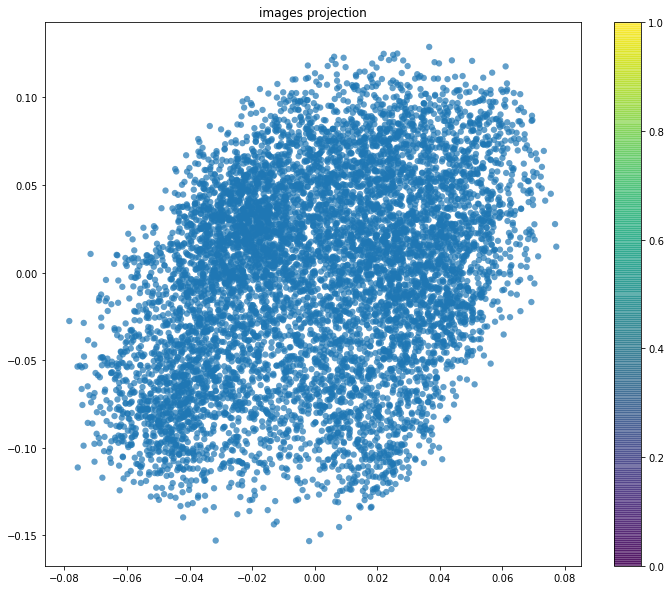

In [200]:
data = X_encode[:, :2]

plt.figure(figsize=(12,10))
plt.scatter(data[:, 0], data[:, 1], edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('images projection')

In [201]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1)

p_field = tsne.fit_transform(X_encode)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8184 samples in 0.016s...
[t-SNE] Computed neighbors for 8184 samples in 2.735s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8184
[t-SNE] Computed conditional probabilities for sample 2000 / 8184
[t-SNE] Computed conditional probabilities for sample 3000 / 8184
[t-SNE] Computed conditional probabilities for sample 4000 / 8184
[t-SNE] Computed conditional probabilities for sample 5000 / 8184
[t-SNE] Computed conditional probabilities for sample 6000 / 8184
[t-SNE] Computed conditional probabilities for sample 7000 / 8184
[t-SNE] Computed conditional probabilities for sample 8000 / 8184
[t-SNE] Computed conditional probabilities for sample 8184 / 8184
[t-SNE] Mean sigma: 0.055701
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.383514
[t-SNE] KL divergence after 1000 iterations: 0.799225


Text(0.5, 1.0, 'images projection')

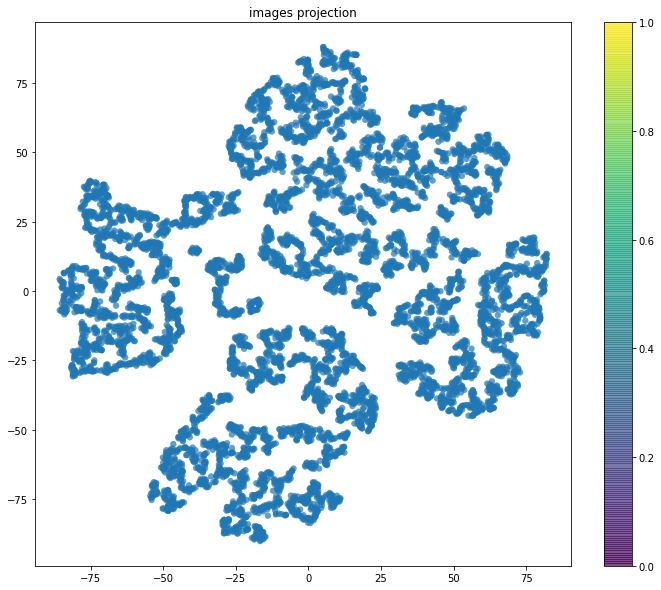

In [202]:
#Convolutional VAE version 2 latent dimention 16 on 305 epoch
data = p_field

plt.figure(figsize=(12,10))
plt.scatter(data[:, 0], data[:, 1], edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('images projection')

C:\Users\iispo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
C:\Users\iispo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
C:\Users\iispo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
C:\Users\iispo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
C:\Users\iis

[(2, 0.5100956552706797), (3, 1.0303089915792334), (4, 0.32826379497975666), (5, 1.0575705808509082), (6, 0.6284348361593736), (7, 0.8391905872229496), (8, 0.7713592666042034), (9, 0.8858677236910889), (10, 0.9152579216680288), (11, 0.8495282678422518), (12, 0.8594314029891033), (13, 0.9593462858518604), (14, 0.9255599468387058), (15, 0.6432212791963172), (16, 0.8274249930172695), (17, 1.0296647717982135), (18, 1.0580739958755632), (19, 1.0160820520019032), (20, 1.0559490247294852), (21, 0.7856528812799138), (22, 1.116440868873947), (23, 0.8699261217435228), (24, 0.9235832996948182), (25, 1.2648629366014859), (26, 0.7120674836483117), (27, 0.8331976402383351), (28, 1.2464854241406302), (29, 0.9323449790233038), (30, 0.842394176487215), (31, 1.1553188078842564), (32, 0.37226640493765817), (33, 1.6202761830397465), (34, 1.2460927183709563), (35, 0.4884472575720782), (36, 1.180158624821888), (37, 1.2824034566753992), (38, 1.1790371715090402), (39, 0.7391307963579032), (40, 1.0457810802060

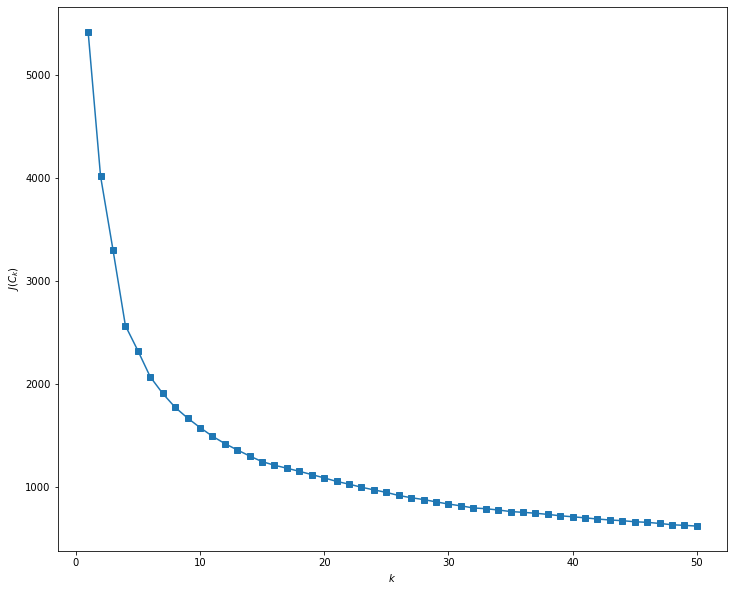

In [203]:
from sklearn.cluster import KMeans

N = [i + 1 for i in range(50)]
inertia = []
for k in N:
    kmeans = KMeans(n_clusters=k, random_state=1, n_jobs=4).fit(p_field)
    inertia.append(np.sqrt(kmeans.inertia_))

d_list = [(i + 1, abs((inertia[i] - inertia[i + 1]) / (inertia[i - 1] - inertia[i])))  for i in range(1, len(inertia) - 1)]
print(d_list)

plt.figure(figsize=(12,10))
plt.plot(N, inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

C:\Users\iispo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
C:\Users\iispo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
C:\Users\iispo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
C:\Users\iispo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
C:\Users\iis

[(2, 0.40714076051439774), (3, 0.8325987292410276), (4, 0.772214290048716), (5, 0.529454095930439), (6, 0.7742784704882206), (7, 0.7569545966413659), (8, 0.9945876533014524), (9, 0.7585610657047391), (10, 0.9200509945450138), (11, 0.9109687849155073), (12, 0.6867312962779781), (13, 1.1710805662660861), (14, 0.8442807971854195), (15, 0.8741934720333044), (16, 0.8942225013384688), (17, 0.9949827765525382), (18, 0.9223474178134895), (19, 0.8371558669515059), (20, 0.9596799143898564), (21, 0.9475891345003389), (22, 0.918817995827246), (23, 0.9508515349685355), (24, 1.0965291797932213), (25, 0.8841588951153865), (26, 0.7512516189026482), (27, 1.1370710983287333), (28, 0.8614722550564731), (29, 0.9426659669534396), (30, 1.2186636606754317), (31, 0.6691270399138805), (32, 1.2151113553034802), (33, 1.0162420897720472), (34, 0.986872730222853), (35, 0.8039691904715792), (36, 0.7543555057422989), (37, 1.306992550411891), (38, 1.1159859819756577), (39, 0.7840521731580758), (40, 0.9645943789543912

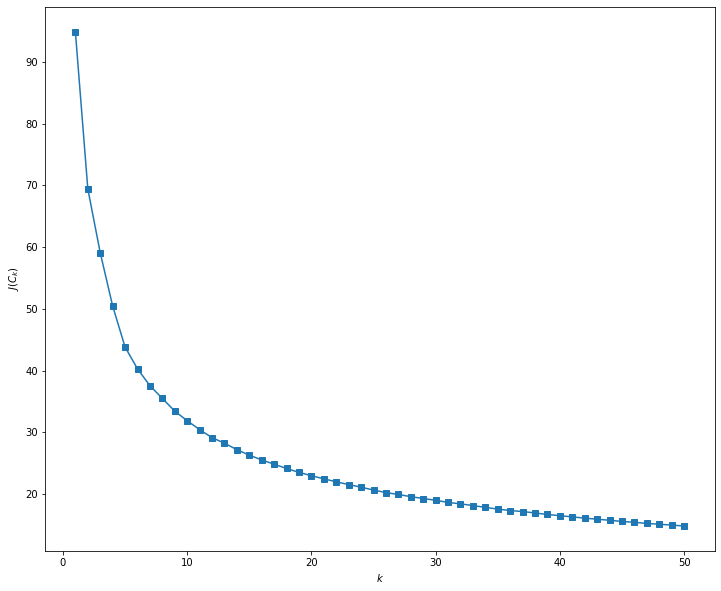

In [204]:
from sklearn.cluster import KMeans

N = [i + 1 for i in range(50)]
inertia = []
for k in N:
    kmeans = KMeans(n_clusters=k, random_state=1, n_jobs=4).fit(X_encode)
    inertia.append(np.sqrt(kmeans.inertia_))

d_list = [(i + 1, abs((inertia[i] - inertia[i + 1]) / (inertia[i - 1] - inertia[i])))  for i in range(1, len(inertia) - 1)]
print(d_list)

plt.figure(figsize=(12,10))
plt.plot(N, inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

In [205]:
kmeans = KMeans(n_clusters=10, random_state=1, n_jobs=4).fit(X_encode)

C:\Users\iispo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


In [154]:
np.sqrt(kmeans.inertia_)

15.936641655041722

In [206]:
import joblib
filename = 'joblib_model.pkl'
joblib.dump(kmeans, filename)

['joblib_model.pkl']